## Autoencoders

#### Data-driven data dimensionality reduction (compression)

An autoencoder is a type of artificial neural network used to learn efficient data codings in an **unsupervised** manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”.

- Map the initial data to a lower dimensional representation (encoder)
- Map back the low dimensional data to initial data size (decoder)

Used for:
- Data denoising
- Dimensionality reduction 

#### Unsupervised: No labels or output values

#### Question: What is the loss function?


Example (from https://blog.keras.io/building-autoencoders-in-keras.html)

In [1]:
#!pip install keras==2.8

from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

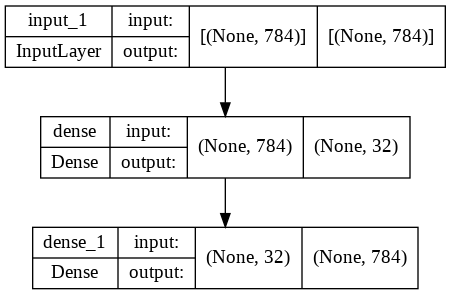

In [2]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, show_shapes=True, show_layer_names=True)

In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

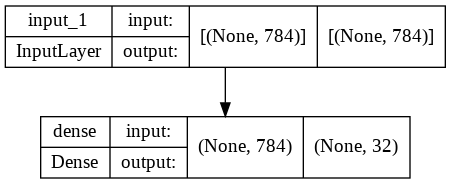

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(encoder, show_shapes=True, show_layer_names=True)

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

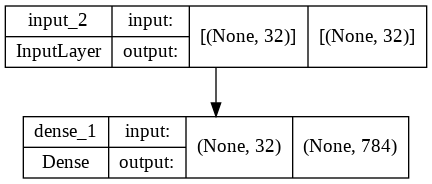

In [6]:
plot_model(decoder, show_shapes=True, show_layer_names=True)

In [7]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 73s 309ms/step - loss: 0.4377 - val_loss: 0.4386
Epoch 2/50
235/235 [==============================] - 70s 300ms/step - loss: 0.4329 - val_loss: 0.4334
Epoch 3/50
235/235 [==============================] - 70s 300ms/step - loss: 0.4276 - val_loss: 0.4277
Epoch 4/50
235/235 [==============================] - 70s 300ms/step - loss: 0.4217 - val_loss: 0.4214
Epoch 5/50
235/235 [==============================] - 71s 300ms/step - loss: 0.4150 - val_loss: 0.4141
Epoch 6/50
235/235 [==============================] - 70s 299ms/step - loss: 0.4074 - val_loss: 0.4057
Epoch 7/50
235/235 [==============================] - 70s 298ms/step - loss: 0.3983 - val_loss: 0.3956
Epoch 8/50
235/235 [==============================] - 69s 296ms/step - loss: 0.3873 - val_loss: 0.3831
Epoch 9/50
235/235 [==============================] - 70s 297ms/step - loss: 0.3743 - val_loss: 0.3692
Epoch 10/50
235/235 [==============================] - 71s 304ms/step - l

In [11]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

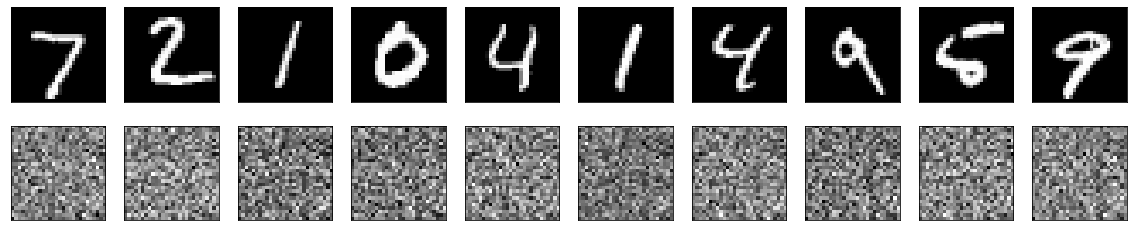

In [12]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [13]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

### Convolutional autoencoder

In [14]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [15]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [16]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
469/469 [==============================] - 76s 161ms/step - loss: 0.6997 - val_loss: 0.6969
Epoch 2/10
469/469 [==============================] - 73s 157ms/step - loss: 0.6938 - val_loss: 0.6903
Epoch 3/10
469/469 [==============================] - 74s 157ms/step - loss: 0.6859 - val_loss: 0.6806
Epoch 4/10
469/469 [==============================] - 74s 157ms/step - loss: 0.6712 - val_loss: 0.6579
Epoch 5/10
469/469 [==============================] - 74s 158ms/step - loss: 0.6261 - val_loss: 0.5768
Epoch 6/10
469/469 [==============================] - 74s 157ms/step - loss: 0.5107 - val_loss: 0.4776
Epoch 7/10
469/469 [==============================] - 74s 157ms/step - loss: 0.4690 - val_loss: 0.4682
Epoch 8/10
469/469 [==============================] - 73s 157ms/step - loss: 0.4606 - val_loss: 0.4601
Epoch 9/10
469/469 [==============================] - 74s 157ms/step - loss: 0.4526 - val_loss: 0.4519
Epoch 10/10
469/469 [==============================] - 78s 166ms/step - l

#### Image denoising

In [17]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [18]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

ValueError: ignored

<Figure size 1440x144 with 0 Axes>

In [ ]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])